In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Display the first few rows of each dataset
print("Customers Data:")
print(customers.head())
print("\nProducts Data:")
print(products.head())
print("\nTransactions Data:")
print(transactions.head())

Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Data:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127 

In [3]:
# Strip whitespace from customer IDs
customers['CustomerID'] = customers['CustomerID'].str.strip()
transactions['CustomerID'] = transactions['CustomerID'].str.strip()

# Create a summary table for each customer
customer_summary = transactions.groupby('CustomerID').agg(
    TotalSpent=('TotalValue', 'sum'),
    PurchaseFrequency=('TransactionID', 'count'),
    LastPurchaseDate=('TransactionDate', 'max')
).reset_index()

# Calculate recency (in days)
customer_summary['LastPurchaseDate'] = pd.to_datetime(customer_summary['LastPurchaseDate'])
customer_summary['Recency'] = (pd.to_datetime('now') - customer_summary['LastPurchaseDate']).dt.days

# Merge with customer profile information
customer_summary = customer_summary.merge(customers, on='CustomerID')

# Display the customer summary
print("\nCustomer Summary:")
print(customer_summary.head())


Customer Summary:
  CustomerID  TotalSpent  PurchaseFrequency    LastPurchaseDate  Recency  \
0      C0001     3354.52                  5 2024-11-02 17:04:16       84   
1      C0002     1862.74                  4 2024-12-03 01:41:41       54   
2      C0003     2725.38                  4 2024-08-24 18:54:04      154   
3      C0004     5354.88                  8 2024-12-23 14:13:52       33   
4      C0005     2034.24                  3 2024-11-04 00:30:22       83   

         CustomerName         Region  SignupDate  
0    Lawrence Carroll  South America  2022-07-10  
1      Elizabeth Lutz           Asia  2022-02-13  
2      Michael Rivera  South America  2024-03-07  
3  Kathleen Rodriguez  South America  2022-10-09  
4         Laura Weber           Asia  2022-08-15  


In [4]:
# Strip whitespace from customer IDs
customers['CustomerID'] = customers['CustomerID'].str.strip()
transactions['CustomerID'] = transactions['CustomerID'].str.strip()

# Create a summary table for each customer
customer_summary = transactions.groupby('CustomerID').agg(
    TotalSpent=('TotalValue', 'sum'),
    PurchaseFrequency=('TransactionID', 'count'),
    LastPurchaseDate=('TransactionDate', 'max')
).reset_index()

# Calculate recency (in days)
customer_summary['LastPurchaseDate'] = pd.to_datetime(customer_summary['LastPurchaseDate'])
customer_summary['Recency'] = (pd.to_datetime('now') - customer_summary['LastPurchaseDate']).dt.days

# Merge with customer profile information
customer_summary = customer_summary.merge(customers, on='CustomerID')

# Display the customer summary
print("\nCustomer Summary:")
print(customer_summary.head())


Customer Summary:
  CustomerID  TotalSpent  PurchaseFrequency    LastPurchaseDate  Recency  \
0      C0001     3354.52                  5 2024-11-02 17:04:16       84   
1      C0002     1862.74                  4 2024-12-03 01:41:41       54   
2      C0003     2725.38                  4 2024-08-24 18:54:04      154   
3      C0004     5354.88                  8 2024-12-23 14:13:52       33   
4      C0005     2034.24                  3 2024-11-04 00:30:22       83   

         CustomerName         Region  SignupDate  
0    Lawrence Carroll  South America  2022-07-10  
1      Elizabeth Lutz           Asia  2022-02-13  
2      Michael Rivera  South America  2024-03-07  
3  Kathleen Rodriguez  South America  2022-10-09  
4         Laura Weber           Asia  2022-08-15  


In [5]:
# Select relevant features for similarity
features = customer_summary[['TotalSpent', 'PurchaseFrequency', 'Recency']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Calculate cosine similarity
similarity_matrix = cosine_similarity(features_scaled)

# Convert to DataFrame for easier handling
similarity_df = pd.DataFrame(similarity_matrix, index=customer_summary['CustomerID'], columns=customer_summary['CustomerID'])

In [6]:
# Function to get top N lookalikes for a given customer
def get_top_lookalikes(customer_id, n=3):
    if customer_id not in similarity_df.index:
        print(f"Customer ID {customer_id} not found in similarity matrix.")
        return []

    # Get similarity scores for the given customer
    scores = similarity_df[customer_id]

    # Sort scores in descending order and get the top N lookalikes
    top_lookalikes = scores.sort_values(ascending=False).head(n + 1)  # +1 to exclude the customer themselves
    top_lookalikes = top_lookalikes.iloc[1:]  # Exclude the customer themselves
    return top_lookalikes

# Create a list to store lookalike records
lookalike_records = []

# Get lookalikes for the first 20 customers
for customer in customer_summary['CustomerID'][:20]:
    lookalikes = get_top_lookalikes(customer)
    for lookalike_id, score in zip(lookalikes.index, lookalikes.values):
        lookalike_records.append((customer, lookalike_id, score))

# Create a DataFrame from the records
lookalike_df = pd.DataFrame(lookalike_records, columns=['CustomerID', 'LookalikeID', 'SimilarityScore'])

# Save to CSV
lookalike_df.to_csv('Lookalike.csv', index=False)

# Display the lookalike results
print("\nLookalike Results:")
print(lookalike_df)


Lookalike Results:
   CustomerID LookalikeID  SimilarityScore
0       C0001       C0190         0.997672
1       C0001       C0191         0.997061
2       C0001       C0056         0.996593
3       C0002       C0031         0.998220
4       C0002       C0083         0.989067
5       C0002       C0029         0.985330
6       C0003       C0112         0.999616
7       C0003       C0097         0.998874
8       C0003       C0144         0.998175
9       C0004       C0101         0.999047
10      C0004       C0068         0.991998
11      C0004       C0136         0.991973
12      C0005       C0123         0.999847
13      C0005       C0036         0.998530
14      C0005       C0078         0.992164
15      C0006       C0168         0.897680
16      C0006       C0026         0.812259
17      C0006       C0066         0.796630
18      C0007       C0120         0.990177
19      C0007       C0150         0.979227
20      C0007       C0130         0.975871
21      C0008       C0084         

<ipython-input-7-cb349adfc9d8>:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


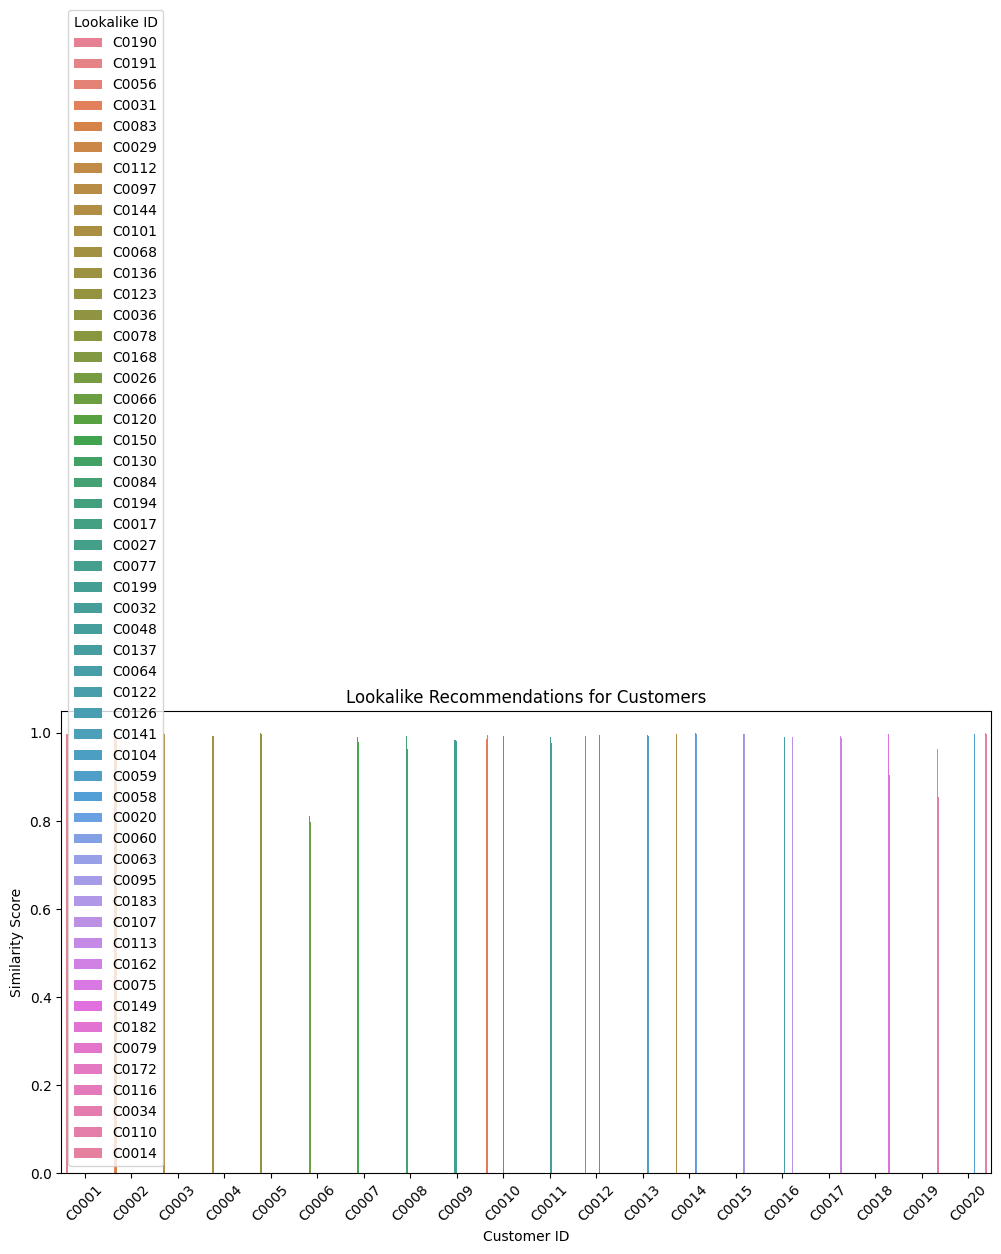

In [7]:
# Visualization of the lookalikes
plt.figure(figsize=(12, 6))
sns.barplot(data=lookalike_df, x='CustomerID', y='SimilarityScore', hue='LookalikeID')
plt.title('Lookalike Recommendations for Customers')
plt.xlabel('Customer ID')
plt.ylabel('Similarity Score')
plt.xticks(rotation=45)
plt.legend(title='Lookalike ID')
plt.tight_layout()
plt.show()

In [8]:
sns.set(style="whitegrid")


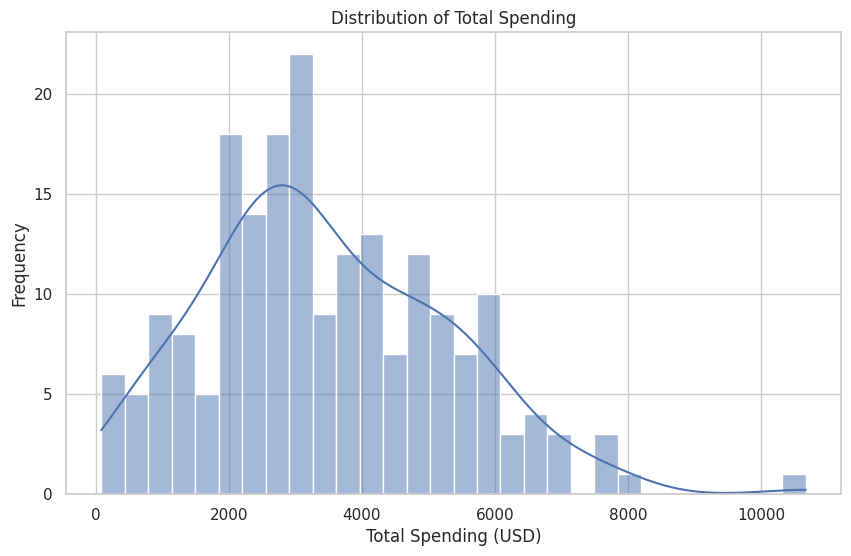

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(customer_summary['TotalSpent'], bins=30, kde=True)
plt.title('Distribution of Total Spending')
plt.xlabel('Total Spending (USD)')
plt.ylabel('Frequency')
plt.show()

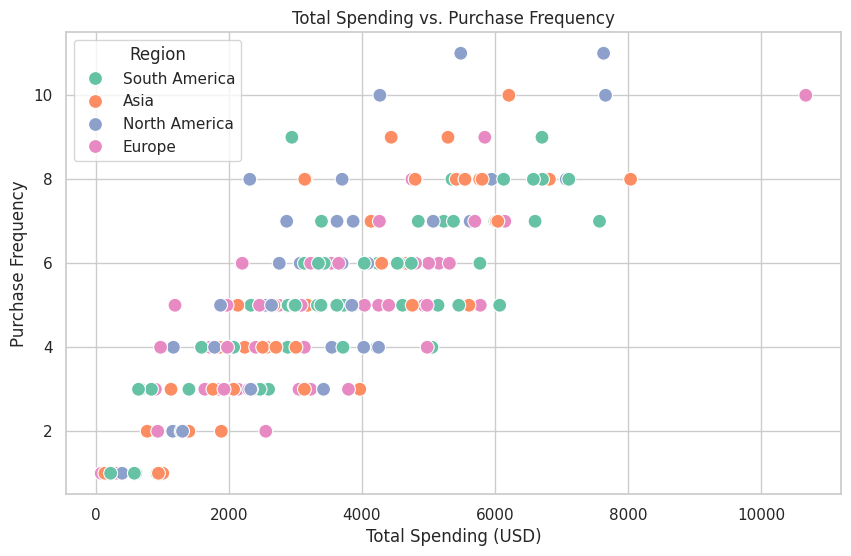

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_summary, x='TotalSpent', y='PurchaseFrequency', hue='Region', palette='Set2', s=100)
plt.title('Total Spending vs. Purchase Frequency')
plt.xlabel('Total Spending (USD)')
plt.ylabel('Purchase Frequency')
plt.legend(title='Region')
plt.show()

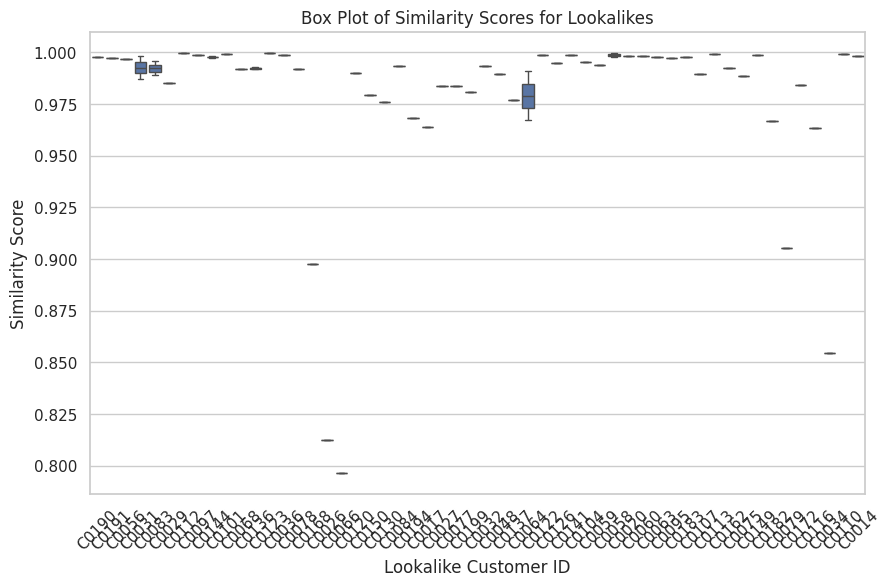

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=lookalike_df, x='LookalikeID', y='SimilarityScore')
plt.title('Box Plot of Similarity Scores for Lookalikes')
plt.xlabel('Lookalike Customer ID')
plt.ylabel('Similarity Score')
plt.xticks(rotation=45)
plt.show()

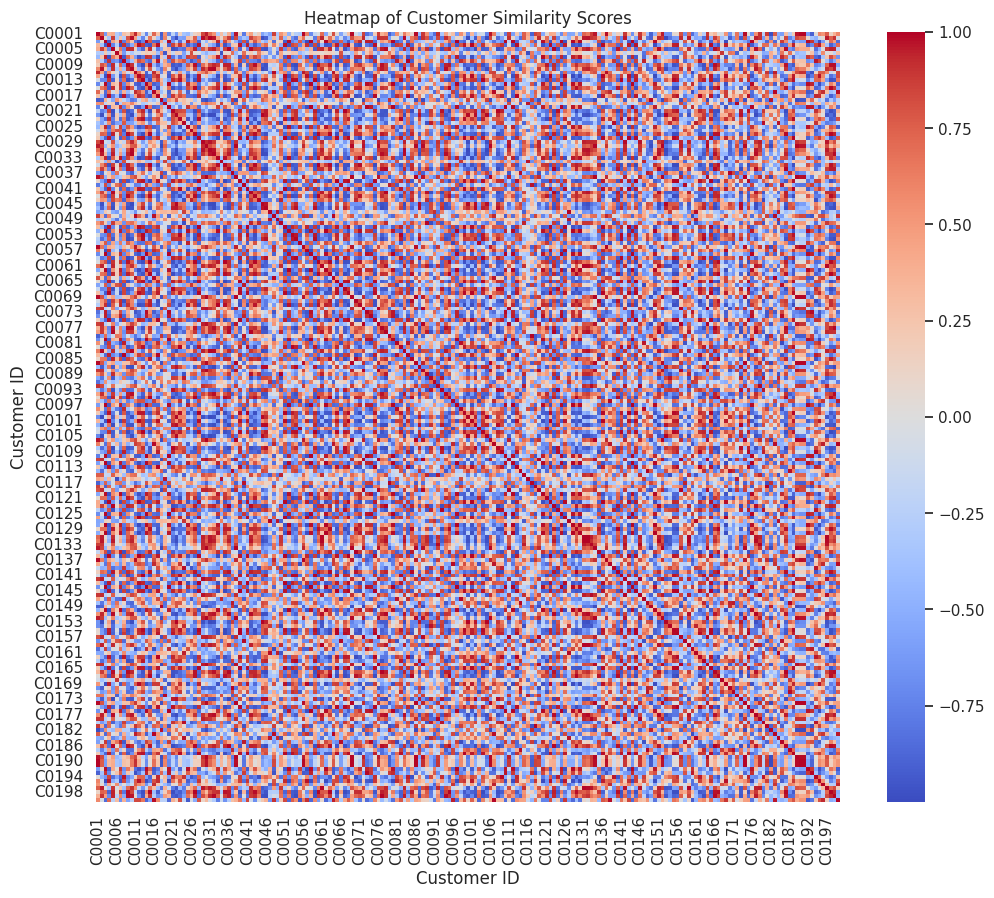

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap='coolwarm', annot=False, fmt=".2f", cbar=True)
plt.title('Heatmap of Customer Similarity Scores')
plt.xlabel('Customer ID')
plt.ylabel('Customer ID')
plt.show()